In [1]:
import os
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import torch, torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder


In [5]:
CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
MODELS_LISTS = []
ACCURACIES = []
EXECUTION_TIMES = []
MOST_DIFFICULT_CLASS = []
TPR_MIN = []

## Carregamento e Preparação dos Dados

In [8]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

viz_train_x = train_dataset.data
viz_train_y = train_dataset.targets

train_x = train_dataset.data.view(train_dataset.data.shape[0], -1).float() / 255.0
test_x = test_dataset.data.view(test_dataset.data.shape[0], -1).float() / 255.0
train_y = train_dataset.targets
test_y = test_dataset.targets

batch_size = 64
train_loader = DataLoader(list(zip(train_x, train_y)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(list(zip(test_x, test_y)), batch_size=batch_size, shuffle=False)


## Análise Exploratória de Dados (EDA)

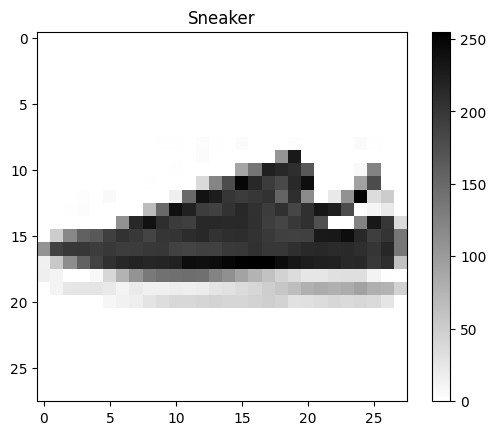

In [9]:
plt.figure()
plt.imshow(viz_train_x[6], cmap=plt.cm.binary)
plt.title(CLASS_NAMES[viz_train_y[6]])
plt.colorbar()
plt.grid(False)
plt.show()

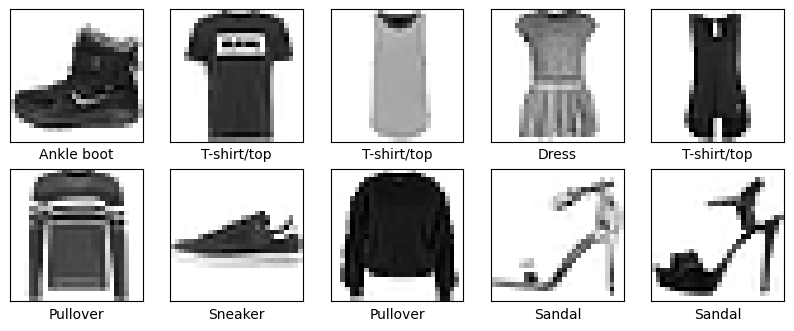

In [10]:
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(viz_train_x[i], cmap=plt.cm.binary)
    plt.xlabel(CLASS_NAMES[viz_train_y[i]])
plt.show()

In [11]:
unique, counts = np.unique(viz_train_y, return_counts=True)
data = {'Class': unique, 'Count': counts}
df = pd.DataFrame(data)

# Gráfico de distribuição das classes
fig = px.bar(df, x='Class', y='Count', text='Count', labels={'Count': 'Frequência', 'Class': 'Classe'},
             title='Distribuição das Classes no Conjunto de Dados de Treinamento', width=1000, height=600)
fig.show()

## Definição de Funções para Treinamento e Avaliação dos Modelos

In [12]:
class SimpleNN(torch.nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = torch.nn.Linear(in_features=784, out_features=128)
        self.fc2 = torch.nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimpleNN().to(device)


In [13]:
def train_neural_network(model_name, model, train_loader, epochs, DEVICE='cuda'):
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

    train_losses = []
    train_accuracies = []

    start_time = time.time()
    for epoch in range(epochs):
        epoch_loss = 0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = epoch_loss / len(train_loader)
        accuracy = correct / total

        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

    exec_time = time.time() - start_time
    return exec_time, train_losses, train_accuracies


In [15]:
def evaluate_model(model_name, model, test_loader, exec_time):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    total = len(all_labels)
    correct = sum(p == l for p, l in zip(all_predictions, all_labels))
    accuracy = correct / total

    print('Classification Report')
    class_report = classification_report(all_labels, all_predictions)
    print(class_report)

    print('\nConfusion Matrix')
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    print(conf_matrix)

    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    TPR = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
    most_difficult_class = TPR.argmin()
    print(f'\nThe most difficult class is {most_difficult_class}')
    print(f'\nExecution time: {exec_time:.2f} seconds')

    return accuracy, conf_matrix, class_report, exec_time, TPR


## Treinamento e Avaliação de Modelos (MLP e CNN)

In [16]:
# Treinando o modelo
epochs = 10  # Defina o número de épocas
exec_time, train_losses, train_accuracies = train_neural_network('SimpleNN', model, train_loader, epochs, DEVICE=device)


Epoch 1/10, Loss: 0.5524, Accuracy: 0.8114
Epoch 2/10, Loss: 0.4050, Accuracy: 0.8577
Epoch 3/10, Loss: 0.3655, Accuracy: 0.8692
Epoch 4/10, Loss: 0.3391, Accuracy: 0.8782
Epoch 5/10, Loss: 0.3195, Accuracy: 0.8850
Epoch 6/10, Loss: 0.3047, Accuracy: 0.8896
Epoch 7/10, Loss: 0.2951, Accuracy: 0.8925
Epoch 8/10, Loss: 0.2880, Accuracy: 0.8958
Epoch 9/10, Loss: 0.2781, Accuracy: 0.8991
Epoch 10/10, Loss: 0.2682, Accuracy: 0.9006


Classification Report
              precision    recall  f1-score   support

           0       0.80      0.87      0.84      1000
           1       0.98      0.97      0.97      1000
           2       0.76      0.82      0.79      1000
           3       0.89      0.85      0.87      1000
           4       0.73      0.88      0.80      1000
           5       0.99      0.90      0.95      1000
           6       0.84      0.56      0.67      1000
           7       0.88      0.98      0.93      1000
           8       0.95      0.97      0.96      1000
           9       0.96      0.93      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000


Confusion Matrix
[[868   6  23  33  11   0  43   1  15   0]
 [  2 974   1  17   4   0   1   0   1   0]
 [ 19   1 824   4 123   0  27   0   2   0]
 [ 22  15  22 852  70   0  12   0   7   0]
 [  1   0  88  13 877   0  18

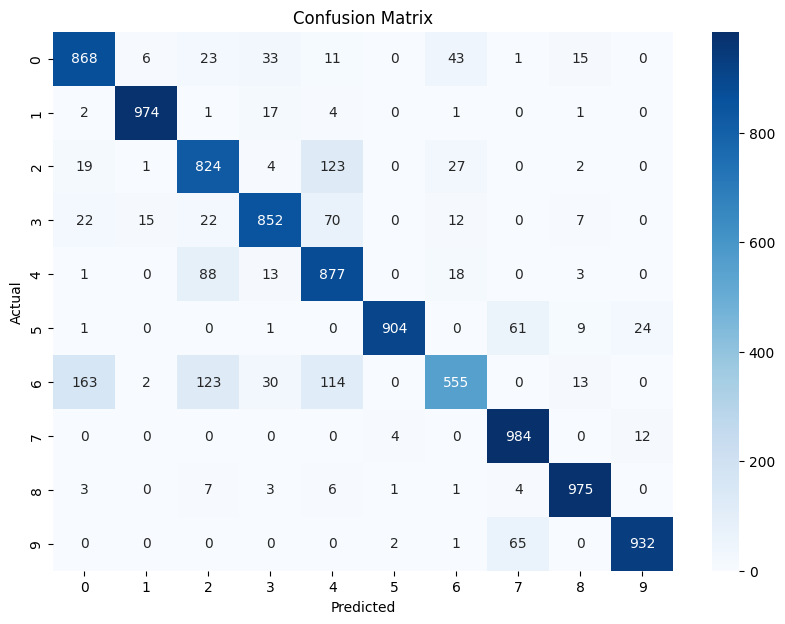


The most difficult class is 6

Execution time: 73.53 seconds


In [17]:
# Avaliando o modelo
accuracy, conf_matrix, class_report, exec_time, TPR = evaluate_model('SimpleNN', model, test_loader, exec_time)


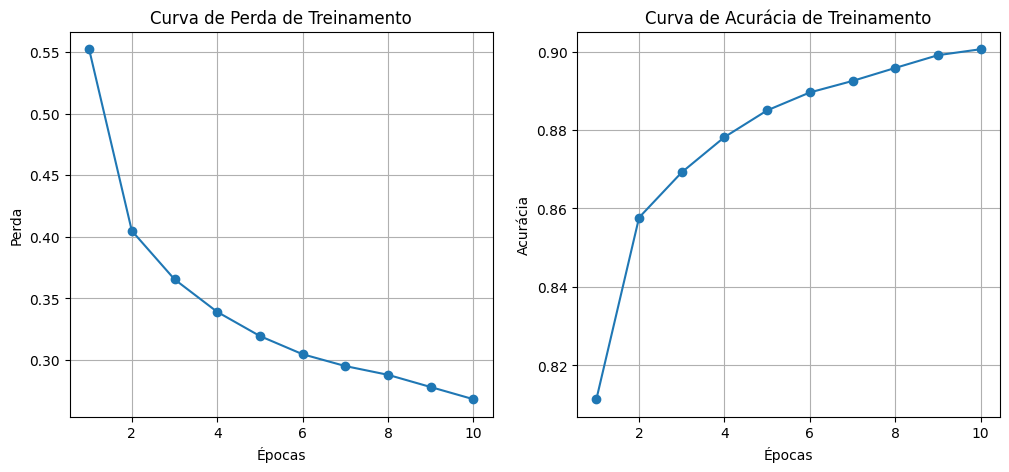

Acurácia: 0.87


In [18]:
# Plotando as curvas de aprendizado
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, marker='o')
plt.title('Curva de Perda de Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, marker='o')
plt.title('Curva de Acurácia de Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.grid()

plt.show()

# Exiba a acurácia final
print(f'Acurácia: {accuracy:.2f}')
